In [53]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [54]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [55]:
NUM_CLASSES = 26

# Dataset reading

In [56]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [57]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [59]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [60]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,356 (5.30 KB)

 Trainable params: 1,356 (5.30 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [62]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [63]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.0078 - loss: 3.4953
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0047 - loss: 3.4834 - val_accuracy: 0.0000e+00 - val_loss: 3.3698
Epoch 2/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 3.4351
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0072 - loss: 3.4009 - val_accuracy: 0.0000e+00 - val_loss: 3.3192
Epoch 3/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0078 - loss: 3.3661
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0101 - loss: 3.3593 - val_accuracy: 0.0000e+00 - val_loss: 3.2717
Epoch 4/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0312 - loss: 3.2744
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier

In [64]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7732 - loss: 0.5067


In [65]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [66]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[1.4687270e-01 2.3739956e-02 2.0285286e-02 4.3824762e-03 8.0005342e-01
 9.4250176e-04 3.0407791e-06 2.2569413e-06 6.9816267e-08 3.8909185e-08
 2.3118109e-07 9.3659096e-08 7.2915775e-08 2.7924364e-06 4.5456186e-06
 2.7946794e-06 5.4817525e-07 5.4648410e-07 2.9118157e-06 3.6827610e-03
 4.1664084e-06 6.2237689e-08 6.0619896e-06 7.0144956e-06 1.0441037e-07
 3.4028685e-06]
4


# Confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step


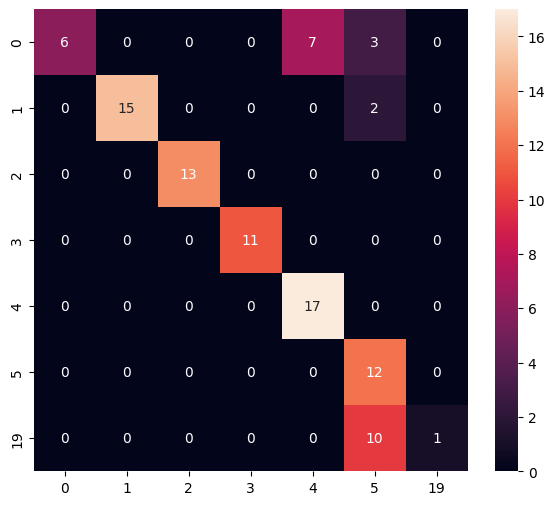

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.38      0.55        16
           1       1.00      0.88      0.94        17
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        11
           4       0.71      1.00      0.83        17
           5       0.44      1.00      0.62        12
          19       1.00      0.09      0.17        11

    accuracy                           0.77        97
   macro avg       0.88      0.76      0.73        97
weighted avg       0.88      0.77      0.74        97



In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [68]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [69]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpe7ais2l7/assets


INFO:tensorflow:Assets written to: /tmp/tmpe7ais2l7/assets


Saved artifact at '/tmp/tmpe7ais2l7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  133180881835152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133180881841104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133180881838608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133180881842448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133180881841872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133180881841296: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1729760117.972864   36244 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1729760117.972875   36244 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-24 05:55:17.972991: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpe7ais2l7
2024-10-24 05:55:17.973246: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-24 05:55:17.973254: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpe7ais2l7
2024-10-24 05:55:17.975500: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-24 05:55:17.989479: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpe7ais2l7
2024-10-24 05:55:17.993770: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 20782 microseconds.


7576

# Inference test

In [70]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [71]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [72]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [73]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 153 μs, sys: 27 μs, total: 180 μs
Wall time: 122 μs


In [74]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.4687268e-01 2.3739923e-02 2.0285266e-02 4.3824771e-03 8.0005366e-01
 9.4250066e-04 3.0407800e-06 2.2569400e-06 6.9816160e-08 3.8909118e-08
 2.3118113e-07 9.3659132e-08 7.2915661e-08 2.7924316e-06 4.5456204e-06
 2.7946776e-06 5.4817389e-07 5.4648427e-07 2.9118169e-06 3.6827563e-03
 4.1664016e-06 6.2237589e-08 6.0619855e-06 7.0144970e-06 1.0441020e-07
 3.4028692e-06]
4
